In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [ ]:
transform=transforms.ToTensor()
train_data=MNIST(root='/data',train=True,transform=transform,download=True)
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.84MB/s]


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class VAE(nn.Module):
  def __init__(self,input_dim,hid_dim=200,z_dim=100):
    super().__init__()

    self.img_2hid=nn.Linear(input_dim,hid_dim)
    self.hid_2mu=nn.Linear(hid_dim,z_dim)
    self.hid_2sigma=nn.Linear(hid_dim,z_dim)

    self.z_2hid=nn.Linear(z_dim,hid_dim)
    self.hid_2img=nn.Linear(hid_dim,input_dim)


    self.relu=nn.ReLU()

  def encode(self,x):
    #q[phi](z|x)
    h=self.img_2hid(x)
    mu=self.hid_2mu(h)
    sigma=self.hid_2sigma(h)

    return mu,sigma
  def decode(self,z):
    h=self.z_2hid(z)
    return torch.sigmoid(self.hid_2img(h))
  def forward(self,x):
    mu,sigma=self.encode(x)
    epsilon=torch.randn(sigma.shape,device=sigma.device)
    x_reparametrized=mu+sigma*epsilon
    x_reconstructed=self.decode(x_reparametrized)
    return x_reconstructed,mu,sigma


In [ ]:
class VAE_CNN(nn.Module):
  def __init__(self,hid_dim=200,z_dim=100):
    super().__init__()
    self.hid_dim=hid_dim

    self.downsample_1=nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1)
    self.downsample_2=nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1)
    self.downsample_3=nn.Conv2d(32,hid_dim,kernel_size=7)
    self.hid_2mu=nn.Linear(hid_dim,z_dim)
    self.hid_2sigma=nn.Linear(hid_dim,z_dim)

    self.z_2hid=nn.Linear(z_dim,hid_dim)
    self.upsample_1=nn.ConvTranspose2d(hid_dim,32,kernel_size=7)
    self.upsample_2=nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,output_padding=1)
    self.upsample_3=nn.ConvTranspose2d(16,1,kernel_size=3,stride=2,padding=1,output_padding=1)


    self.relu=nn.ReLU()

  def encode(self,x):
    #q[phi](z|x)
    h=self.downsample_3(self.relu(self.downsample_2(self.relu(self.downsample_1(x))))).view(-1,self.hid_dim)
    mu=self.hid_2mu(h)
    sigma=self.hid_2sigma(h)

    return mu,sigma
  def decode(self,z):
    h=self.z_2hid(z).view(-1,self.hid_dim,1,1)
    return torch.sigmoid(self.upsample_3(self.relu(self.upsample_2(self.relu(self.upsample_1(h))))))
  def forward(self,x):
    mu,sigma=self.encode(x)
    epsilon=torch.randn(sigma.shape,device=sigma.device)
    x_reparametrized=mu+sigma*epsilon
    x_reconstructed=self.decode(x_reparametrized)
    return x_reconstructed,mu,sigma


In [ ]:
model=VAE_CNN().to(device)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
crit=nn.BCELoss(reduction='sum')

In [ ]:
beta=0.5
for epoch in range(3):
  for x,_ in tqdm(train_loader):
    x=x.to(device)#.view(-1,784)

    x_reconstructed,mu,sigma=model(x)

    recontructed_loss=crit(x_reconstructed,x)
    kl_div=-torch.sum(1+torch.log(sigma.pow(2))-mu.pow(2)-sigma.pow(2))

    loss=recontructed_loss+beta*kl_div

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch:{epoch+1} Loss:{loss}")



100%|██████████| 1875/1875 [01:17<00:00, 24.17it/s]


Epoch:1 Loss:4042.0224609375


100%|██████████| 1875/1875 [01:21<00:00, 23.06it/s]


Epoch:2 Loss:3555.880859375


100%|██████████| 1875/1875 [01:21<00:00, 23.14it/s]

Epoch:3 Loss:3382.777099609375


# Test

## 1

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# for x_test,_ in train_loader:
#   x_test=x_test.to(device)
#   img_out,_,_=model(x_test)#.view(-1,784))
#   img_out=img_out[0].view(28,28)
#   break

In [ ]:
mu_test=torch.randn([1,100]).to(device)
sigma_test=torch.randn([1,100]).to(device)
e_test=torch.randn(sigma_test.shape).to(device)
z_test=mu_test+sigma_test*e_test

In [ ]:
img_out=model.decode(z_test).view(28,28)

In [ ]:
img_out.shape

torch.Size([28, 28])

In [ ]:
# x_test_img=x_test.cpu().detach().numpy()[0][0]

In [ ]:
# plt.imshow(x_test_img,cmap='gray')

In [ ]:
img_out=img_out.cpu().detach().numpy()

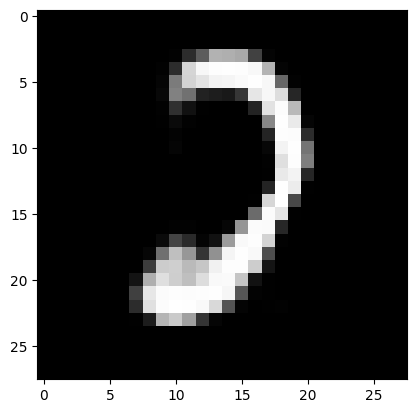

In [ ]:
plt.imshow(img_out,cmap='gray')


## 2

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for x_test,_ in train_loader:
  x_test=x_test.to(device)
  img_out,_,_=model(x_test)#.view(-1,784))
  img_out=img_out[0].view(28,28)
  break

In [ ]:
# mu_test=torch.randn([1,100]).to(device)
# sigma_test=torch.randn([1,100]).to(device)
# e_test=torch.randn(sigma_test.shape).to(device)
# z_test=mu_test+sigma_test*e_test

In [ ]:
# img_out=model.decode(z_test).view(28,28)

In [ ]:
img_out.shape

torch.Size([28, 28])

In [ ]:
x_test_img=x_test.cpu().detach().numpy()[0][0]

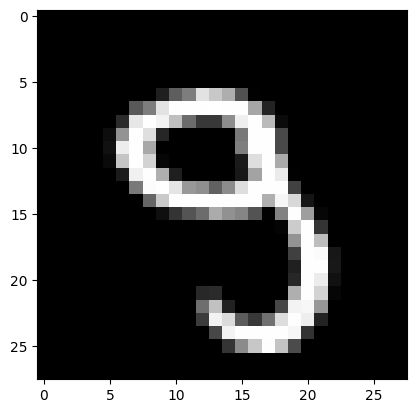

In [ ]:
plt.imshow(x_test_img,cmap='gray')

In [ ]:
img_out=img_out.cpu().detach().numpy()

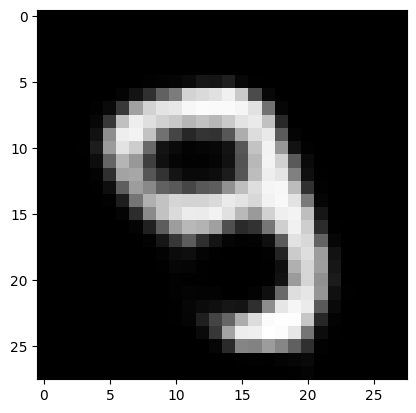

In [ ]:
plt.imshow(img_out,cmap='gray')
